<a href="https://colab.research.google.com/github/brentwilder/Test-Area/blob/master/GEE_TSARS_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NO2 concentrations in Downtown LA during COVID-19 lockdown using GEE
#### TSARS Seminar, Spring 2022

![LA](https://content.presspage.com/uploads/2110/1920_los-angeles-cedars-sinai-covid-gettyimages2.jpg?10000)



In [ ]:
# Run all of the things needed to get GEE going in colab
# along with some other libraries needed for this notebook
!pip install earthengine-api
!earthengine authenticate
!pip install geemap
import pandas as pd
from google.colab import auth
auth.authenticate_user()
import ee
ee.Initialize()
import geemap 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=6ds9_J2cjdJ9nVcOjJ9yHEtL5q0bhiDkbqXdad-npqo&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjIs78Xh1clWHiLwcFsy9Zq8ZkkWcB-5JxW_e8jduq5HnaSG2pfJXA

Successfully saved authorization token.


### First, let's look at an interactive map of the data. You can use the top right button in the map viewer to adjust the layers.

Information on the Nitrogen Dioxide data can be found here: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_OFFL_L3_NO2#description

In [ ]:
# Define our area of interest (Los Angeles , California)
area = ee.Feature(ee.Geometry.Rectangle(-118.74553648325988, 33.59967040156815,-117.06188169810363 ,34.3784997410474))

In [ ]:
# Load images for March 2019, March 2020, March 2021, and March 2022
March2019 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2').select('tropospheric_NO2_column_number_density').filterDate('2019-03-01', '2019-04-01')
March2020 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2').select('tropospheric_NO2_column_number_density').filterDate('2020-03-01', '2020-04-01')
March2021 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2').select('tropospheric_NO2_column_number_density').filterDate('2021-03-01', '2021-04-01')
March2022 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2').select('tropospheric_NO2_column_number_density').filterDate('2022-03-01', '2022-04-01')

# Composite, clip, and set projection
March2019 = March2019.mean().setDefaultProjection(March2019.first().projection()).clip(area)
March2020 = March2020.mean().setDefaultProjection(March2020.first().projection()).clip(area)
March2021 = March2021.mean().setDefaultProjection(March2021.first().projection()).clip(area)
March2022 = March2022.mean().setDefaultProjection(March2022.first().projection()).clip(area)

In [ ]:
# Get a quick visualization in geemap of the different images
Map = geemap.Map()

vis_params = {'min': 0, 'max': 0.0002, 'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}

# Add Earth Engine layers to Map
Map.addLayer(March2019,vis_params,'March 2019 NO2')
Map.addLayer(March2020,vis_params,'March 2020 NO2')
Map.addLayer(March2021,vis_params,'March 2021 NO2')
Map.addLayer(March2022,vis_params,'March 2022 NO2')
Map.centerObject(March2020, 9)

# Set parameters for the color bar
colors = vis_params['palette']
vmin = vis_params['min']
vmax = vis_params['max']
Map.add_colorbar_branca(colors=colors,vmin=vmin,vmax=vmax,layer_name="NO2 (column number density)")
Map.addLayerControl()
Map

Map(center=[33.99135671299309, -117.90370909068172], controls=(WidgetControl(options=['position', 'transparent…

### Next, we convert the Earth Engine object into a 2d Numpy array to make more accessible for plotting and statistics

In [ ]:
# BORROWED FUNCTIONS FROM https://mygeoblog.com/2019/08/21/google-earth-engine-to-numpy/

# export the latitude, longitude and array
def LatLonImg(img):
    img = img.addBands(ee.Image.pixelLonLat())
 
    img = img.reduceRegion(reducer=ee.Reducer.toList(),geometry=area.geometry())
 
    data = np.array((ee.Array(img.get("tropospheric_NO2_column_number_density")).getInfo()))
    lats = np.array((ee.Array(img.get("latitude")).getInfo()))
    lons = np.array((ee.Array(img.get("longitude")).getInfo()))
    return lats, lons, data
 
# covert the lat, lon and array into an image
def toImage(lats,lons,data):
 
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)
 
    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)
    nrows = len(uniqueLats)
 
    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0]
    xs = uniqueLons[1] - uniqueLons[0]
 
    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32) #-9999
 
    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    return arr

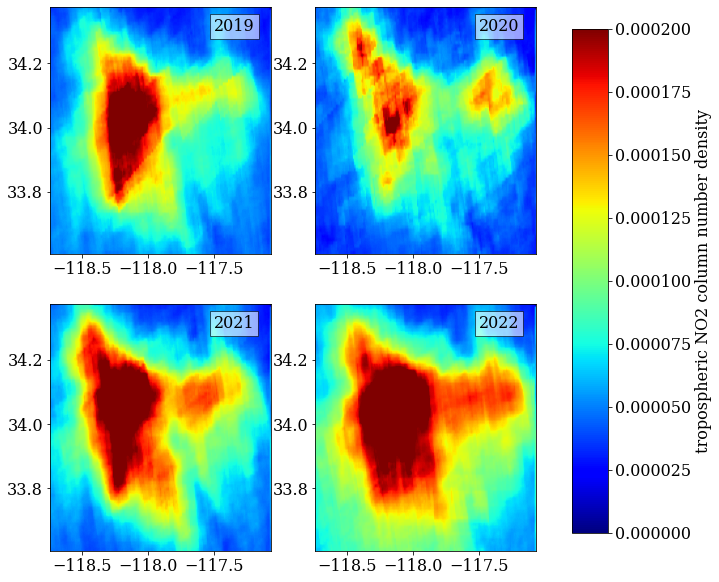

In [ ]:
# Create subplots of the four images for publication/conference style 
# Set font size and font family
plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Create figure object, axes, and subplots
fig, ax = plt.subplots(2,2,figsize =(10, 10))

## TOP LEFT PLOT ########
# get the lon, lat and result as 1d array
lat, lon, data = LatLonImg(March2019)
# 1d to 2d array
image2019  = toImage(lat,lon,data)
ax[0,0].imshow(image2019, extent=[lon.min(), lon.max(), lat.min(),lat.max()],vmin=0, vmax=0.0002, cmap='jet', aspect='auto')
ax[0,0].text(-117.5,34.3,'2019',bbox=dict(facecolor='white', alpha=0.6))

## TOP RIGHT PLOT ########
# get the lon, lat and result as 1d array
lat, lon, data = LatLonImg(March2020)
# 1d to 2d array
image2020 = toImage(lat,lon,data)
ax[0,1].imshow(image2020, extent=[lon.min(), lon.max(), lat.min(),lat.max()],vmin=0, vmax=0.0002, cmap='jet', aspect='auto')
ax[0,1].text(-117.5,34.3,'2020',bbox=dict(facecolor='white', alpha=0.6))

## BOTTOM LEFT PLOT ########
# get the lon, lat and result as 1d array
lat, lon, data = LatLonImg(March2021)
# 1d to 2d array
image2021 = toImage(lat,lon,data)
ax[1,0].imshow(image2021, extent=[lon.min(), lon.max(), lat.min(),lat.max()],vmin=0, vmax=0.0002, cmap='jet', aspect='auto')
ax[1,0].text(-117.5,34.3,'2021',bbox=dict(facecolor='white', alpha=0.6))

## BOTTOM RIGHT PLOT ########
# get the lon, lat and result as 1d array
lat, lon, data = LatLonImg(March2022)
# 1d to 2d array
image2022 = toImage(lat,lon,data)
sp = ax[1,1].imshow(image2022, extent=[lon.min(), lon.max(), lat.min(),lat.max()],vmin=0, vmax=0.0002, cmap='jet', aspect='auto')
ax[1,1].text(-117.5,34.3,'2022',bbox=dict(facecolor='white', alpha=0.6))

# Adjust the color bar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(sp, cax=cbar_ax,label='tropospheric NO2 column number density')

plt.show()

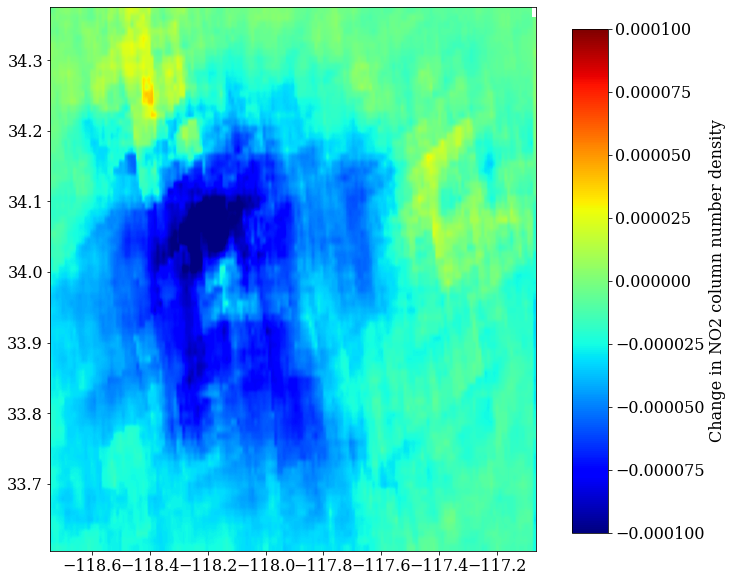

In [ ]:
# we can also compare the non-lockdown time (2019,2021,2022) with lockdown (2020)
nonlockdown =  np.mean([image2019,image2021,image2022],axis=0)
lockdown =  np.mean([image2020],axis=0)

# remove zero values
nonlockdown[nonlockdown == 0] = np.nan
lockdown[lockdown == 0] = np.nan

# Then look at the difference
dNO2 =  lockdown - nonlockdown 

# Create figure object, axes, and subplots
fig, ax = plt.subplots(1,1,figsize =(10, 10))

change = ax.imshow(dNO2, extent=[lon.min(), lon.max(), lat.min(),lat.max()],vmin=-0.0001, vmax=0.0001, cmap='jet', aspect='auto')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(change, cax=cbar_ax,label='Change in NO2 column number density')
plt.show()

### Finally, plot some boxplots to look at the difference between lockdown/non-lockdown 

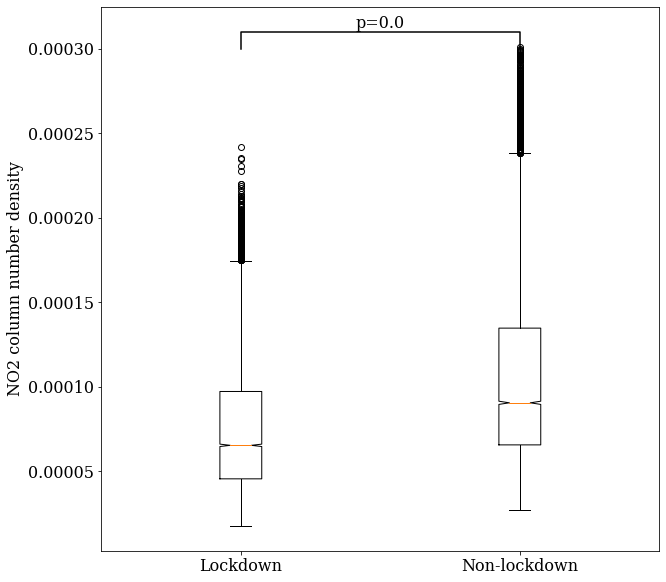

In [ ]:
# More visualization of data using boxplots
ld = lockdown.flatten()
nld = nonlockdown.flatten()

# remove nans 
ld = ld[~np.isnan(ld)]
nld = nld[~np.isnan(nld)]

# Create figure object, axes, and subplots
fig, ax = plt.subplots(1,1,figsize =(10, 10))

ax.boxplot([ld,nld],notch=1)

# statistical annotation
tvalue, pvalue = stats.ttest_ind(ld, nld)
x1, x2 = 1, 2   # columns 
y, h, col = 0.0003, 0.00001, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "p="+str(pvalue), ha='center', va='bottom', color=col)


ax.set_xticklabels(['Lockdown', 'Non-lockdown'])
ax.set_ylabel('NO2 column number density')
plt.show()